In [1]:
if "google.colab" in str(get_ipython()):
    from google.colab import drive
    import os
    drive.mount("/content/gdrive")
    os.chdir("/content/gdrive/My Drive/CS4243 Project/temp")
    !pwd
    %pip install -q ipywidgets
    %pip install -q -r requirements_colab.txt
else:
    %pip install -q -r requirements.txt

# may need to restart the kernel after installing new packages

Note: you may need to restart the kernel to use updated packages.


# Baseline (Multi-Layer Perceptron)

In [1]:
%reset

import torch
import torch.nn as nn

import numpy as np

In [2]:
from utils import load_tensor

train_x, train_y = load_tensor("unaug", "64")
test_x, test_y = load_tensor("test", "64")

train_x.size(), train_y.size()

(torch.Size([5152, 3, 64, 64]), torch.Size([5152]))

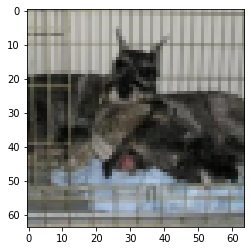

In [3]:
from utils import render_2d

idx = np.random.choice(train_x.size(0))
render_2d(train_x[idx])

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [5]:
train_x, train_y = train_x.to(device), train_y.to(device)
test_x, test_y = test_x.to(device), test_y.to(device)

## Build MLP

In [6]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=5):
        super(MLP, self).__init__()
        assert num_layers >= 2

        self.layers = nn.ModuleList(
            [nn.Sequential(nn.Linear(input_size, hidden_size), nn.ReLU())]
            + [
                nn.Sequential(nn.Linear(hidden_size, hidden_size), nn.ReLU())
                for i in range(2, num_layers)
            ]
            + [nn.Linear(hidden_size, output_size)]
        )
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

### Training

In [7]:
net = MLP(12288, 768, 10)
net

MLP(
  (layers): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=12288, out_features=768, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=768, out_features=768, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=768, out_features=768, bias=True)
      (1): ReLU()
    )
    (3): Sequential(
      (0): Linear(in_features=768, out_features=768, bias=True)
      (1): ReLU()
    )
    (4): Linear(in_features=768, out_features=10, bias=True)
  )
)

In [15]:
from utils import plot_experiments, run_experiments, save_results

def init_func():
    net = MLP(12288, 768, 10).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(net.parameters(), lr=1e-4)

    return (net, criterion, optimizer)

df_unaug = run_experiments(init_func, (train_x, train_y), (test_x, test_y), (12288,))
save_results(df_unaug, "baseline_mlp", "unaug", "64")

  0%|          | 0/100 [00:00<?, ?it/s]

Experiment 0 (e4c2b29b):
epoch = 0	 loss = 2.158	 accuracy = 0.168	 test accuracy = 0.158
epoch = 10	 loss = 1.991	 accuracy = 0.263	 test accuracy = 0.235
epoch = 20	 loss = 1.856	 accuracy = 0.329	 test accuracy = 0.280


  0%|          | 0/100 [00:00<?, ?it/s]

Experiment 1 (fbf29aa6):
epoch = 0	 loss = 2.160	 accuracy = 0.173	 test accuracy = 0.155
epoch = 10	 loss = 1.993	 accuracy = 0.261	 test accuracy = 0.258
epoch = 20	 loss = 1.846	 accuracy = 0.341	 test accuracy = 0.237


  0%|          | 0/100 [00:00<?, ?it/s]

Experiment 2 (7ae2af72):
epoch = 0	 loss = 2.155	 accuracy = 0.167	 test accuracy = 0.172
epoch = 10	 loss = 1.976	 accuracy = 0.271	 test accuracy = 0.250
epoch = 20	 loss = 1.840	 accuracy = 0.332	 test accuracy = 0.280
epoch = 30	 loss = 1.704	 accuracy = 0.389	 test accuracy = 0.258
epoch = 40	 loss = 1.455	 accuracy = 0.489	 test accuracy = 0.277


  0%|          | 0/100 [00:00<?, ?it/s]

Experiment 3 (fe010463):
epoch = 0	 loss = 2.148	 accuracy = 0.170	 test accuracy = 0.162
epoch = 10	 loss = 1.980	 accuracy = 0.269	 test accuracy = 0.272
epoch = 20	 loss = 1.849	 accuracy = 0.329	 test accuracy = 0.292
epoch = 30	 loss = 1.670	 accuracy = 0.405	 test accuracy = 0.278


  0%|          | 0/100 [00:00<?, ?it/s]

Experiment 4 (6d9d0b06):
epoch = 0	 loss = 2.152	 accuracy = 0.175	 test accuracy = 0.172
epoch = 10	 loss = 1.986	 accuracy = 0.266	 test accuracy = 0.268
epoch = 20	 loss = 1.838	 accuracy = 0.336	 test accuracy = 0.292
epoch = 30	 loss = 1.683	 accuracy = 0.398	 test accuracy = 0.265


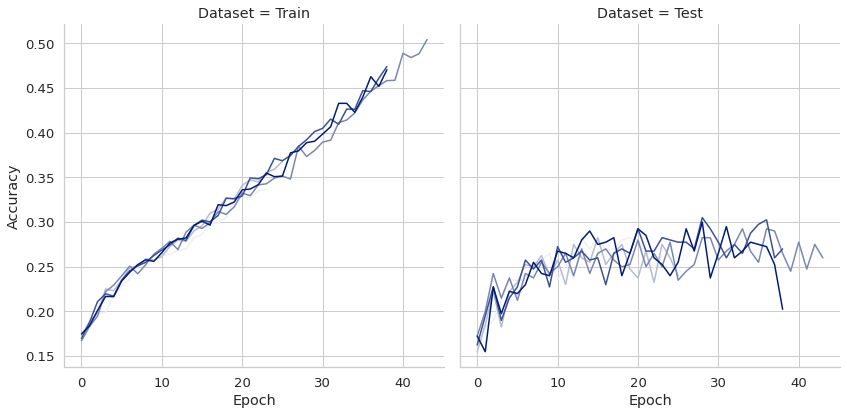

In [16]:
plot_experiments(df_unaug)